<h2>Imports</h2>

In [28]:
from utils import read_results_csv, extract_analysis_parameters, show_exploratory_data, qc_filter_dataset, plot_technical_replicates

<h2>Data analysis input</h2>

In [29]:
# Define the dataset results that you want to analyze below ("microglia" or "astrocyte")
dataset = "microglia"

# Define the .csv results you want to explore and quality check
csv_path = "./results/microglia_results_cellpdia30_sigma1_dilrad4_dnad_obj_seg_v1_gliaero6_gliathr20_dnadero2.csv"

# Read both results and mouse_id .csv files and load them into a Dataframe 
df, df_mouse_id, merged_df = read_results_csv(dataset, csv_path)

# Print the analysis settings and extract them into variables
cellpose_nuclei_diameter, gaussian_sigma, dilation_radius_nuclei, dna_damage_segmenter_version, glia_nuclei_colocalization_erosion, glia_channel_threshold, glia_segmenter, glia_segmenter_version, dna_damage_erosion, parameters_title = extract_analysis_parameters(csv_path)

# Display the first few rows of the DataFrame
merged_df.head()


The following dataset will be analyzed: microglia
Cellpose nuclei diameter: 30
Gaussian sigma: 1
Dilation radius nuclei: 4
Dna damage segmenter version: 1
Glia erosion: 6
Glia threshold: 20
Glia semantic segmentation version: None
DNA damage foci erosion: 2


,index,filename,avg_dna_damage_foci/glia_+,avg_dna_damage_foci/glia_+_damage_+,avg_dna_damage_foci/all_nuclei,avg_dna_damage_foci/all_nuclei_damage_+,nr_+_dna_damage_glia_nuclei,nr_+_dna_damage_all_nuclei,nr_-_dna_damage_glia_nuclei,nr_glia_+_nuclei,...,%_glia+_signal,damage_load_ratio_glia_+_cells,damage_load_ratio_all_cells,tissue_location,staining_id,animal_id,sex,genotype,dna_damage_stain_quality_manual,manual_qc
0,0,DSB Iba1 101_40X_CA1,1.000000,1.333333,0.573333,1.409836,9,61,3,12,...,1.677990,0.750000,0.406667,CA1,101,2119,female,APP/PS1,good,passed
1,1,DSB Iba1 101_40X_CA3,0.777778,1.000000,0.934959,1.513158,7,76,2,9,...,2.135658,0.777778,0.617886,CA3,101,2119,female,APP/PS1,good,passed
2,2,DSB Iba1 101_40X_CTX1,1.100000,1.375000,0.958084,1.415929,24,113,6,30,...,5.073738,0.800000,0.676647,CTX1,101,2119,female,APP/PS1,good,passed
3,3,DSB Iba1 101_40X_CTX2,1.363636,1.666667,0.898374,1.407643,9,157,2,11,...,5.266762,0.818182,0.638211,CTX2,101,2119,female,APP/PS1,good,passed
4,4,DSB Iba1 101_40X_CTX3,0.533333,1.333333,0.759657,1.301471,6,136,9,15,...,3.178596,0.400000,0.583691,CTX3,101,2119,female,APP/PS1,good,passed


<h2>Initial data exploration</h2>

In [30]:
show_exploratory_data(df, dataset, parameters_title)

<h2>Data filtration and quality control (QC)</h2>

In case there are outliers in the % of glial and dna damage mask positive signal (suboptimal stain) one can filter the data to remove those suboptimal stains and just plot the optimal ones where the automated image analysis offers reliable results. The images passing and not passing quality control can be individually checked in the next two Juypter notebooks. 

The stain quality can be filtered by applying a simple rule, any % of glia or dna_damage signal that is <code>quality factor</code> times above the average across all samples will be considered an outlier. The logic behind it is to remove overdetection or overclassification of dna_damage or marker positive cells across an evenly distributed population.

In [31]:
# Stain quality factor
quality_factor = 6

# Quality check the analyzed stainings based on deviations from the mean of both %_glia_signal and %_dna_damage_signal
merged_df = qc_filter_dataset(merged_df,
                              dataset, 
                              cellpose_nuclei_diameter, 
                              gaussian_sigma, 
                              dilation_radius_nuclei, 
                              dna_damage_segmenter_version, 
                              glia_nuclei_colocalization_erosion, 
                              glia_channel_threshold, 
                              glia_segmenter, 
                              glia_segmenter_version, 
                              dna_damage_erosion,
                              quality_factor)

# Dataframe now displays the QC values
merged_df.head()

Glia_mask_area_%_mean: 3.339114447532616, Dna_damage_mask_area_%_mean: 1.199315451636103


,index,filename,avg_dna_damage_foci/glia_+,avg_dna_damage_foci/glia_+_damage_+,avg_dna_damage_foci/all_nuclei,avg_dna_damage_foci/all_nuclei_damage_+,nr_+_dna_damage_glia_nuclei,nr_+_dna_damage_all_nuclei,nr_-_dna_damage_glia_nuclei,nr_glia_+_nuclei,...,tissue_location,staining_id,animal_id,sex,genotype,dna_damage_stain_quality_manual,manual_qc,glia_stain_quality_auto,dna_damage_stain_quality_auto,staining_qc_passed
0,0,DSB Iba1 101_40X_CA1,1.000000,1.333333,0.573333,1.409836,9,61,3,12,...,CA1,101,2119,female,APP/PS1,good,passed,optimal,optimal,True
1,1,DSB Iba1 101_40X_CA3,0.777778,1.000000,0.934959,1.513158,7,76,2,9,...,CA3,101,2119,female,APP/PS1,good,passed,optimal,optimal,True
2,2,DSB Iba1 101_40X_CTX1,1.100000,1.375000,0.958084,1.415929,24,113,6,30,...,CTX1,101,2119,female,APP/PS1,good,passed,optimal,optimal,True
3,3,DSB Iba1 101_40X_CTX2,1.363636,1.666667,0.898374,1.407643,9,157,2,11,...,CTX2,101,2119,female,APP/PS1,good,passed,optimal,optimal,True
4,4,DSB Iba1 101_40X_CTX3,0.533333,1.333333,0.759657,1.301471,6,136,9,15,...,CTX3,101,2119,female,APP/PS1,good,passed,optimal,optimal,True


<h2>Plot technical replicates</h2>

First we will plot technical replicates without averaging them into biological replicas

In [32]:
# Remove data from images with a poor quality stain (auto QC), copy to avoid warnings
auto_filtered_df = merged_df[merged_df['staining_qc_passed'] == True].copy()

# Create a new column for combined sex and tissue location
auto_filtered_df['sex_tissue'] = auto_filtered_df['sex'] + ' - ' + auto_filtered_df['tissue_location']

# Define the order of the categories to ensure that male and female for each tissue location are side by side
categories = [
    'male - CA1', 'female - CA1',
    'male - CA3', 'female - CA3',
    'male - CTX1', 'female - CTX1',
    'male - CTX2', 'female - CTX2',
    'male - CTX3', 'female - CTX3',
    'male - DG', 'female - DG'
]

In [33]:
plot_technical_replicates(auto_filtered_df, categories, dataset, parameters_title)

<h2>Aggregate tissue location results and plot biological replicates</h2>

In [34]:
# Define aggregation rules for each column
aggregations = {
    'nr_+_dna_damage_glia_nuclei': 'sum',
    'nr_+_dna_damage_all_nuclei': 'sum',
    'nr_glia_+_nuclei': 'sum',
    'nr_total_nuclei': 'sum',
    'sex': 'first',  # 'sex' does not vary within each animal_id
    'genotype': 'first'  # 'genotype' does not vary within each animal_id
}

# Group by 'animal_id' and apply the defined aggregation rules
grouped = auto_filtered_df.groupby('animal_id').agg(aggregations)

# Reset index to make 'animal_id' a column
result_df = grouped.reset_index()

# Calculate damage_load_ratio_glia_+
result_df['damage_load_ratio_glia_+'] = result_df['nr_+_dna_damage_glia_nuclei'] / result_df['nr_glia_+_nuclei']

# Calculate damage_load_ratio_total
result_df['damage_load_ratio_total'] = result_df['nr_+_dna_damage_all_nuclei'] / result_df['nr_total_nuclei']

# Save aggregated results as a .csv file
if glia_segmenter:
        result_df.to_csv(
            f"./results/agg_{dataset}_results_cellpdia{cellpose_nuclei_diameter}_sigma{gaussian_sigma}_dilrad{dilation_radius_nuclei}_dnad_obj_seg_v{dna_damage_segmenter_version}_gliaero{glia_nuclei_colocalization_erosion}_glia_sem_seg_v{glia_segmenter_version}_dnadero{dna_damage_erosion}.csv",
            index=False,
        )
else:
    result_df.to_csv(
        f"./results/agg_{dataset}_results_cellpdia{cellpose_nuclei_diameter}_sigma{gaussian_sigma}_dilrad{dilation_radius_nuclei}_dnad_obj_seg_v{dna_damage_segmenter_version}_gliaero{glia_nuclei_colocalization_erosion}_gliathr{glia_channel_threshold}_dnadero{dna_damage_erosion}.csv",
        index=False,
    )

# Display the new DataFrame
result_df

,animal_id,nr_+_dna_damage_glia_nuclei,nr_+_dna_damage_all_nuclei,nr_glia_+_nuclei,nr_total_nuclei,sex,genotype,damage_load_ratio_glia_+,damage_load_ratio_total
0,1887,134,2175,190,3499,male,APP/PS1 x Neil3 KO,0.705263,0.621606
1,1891,171,1968,272,3571,female,APP/PS1 x Neil3 KO,0.628676,0.551106
2,1989,31,842,72,1923,female,APP/PS1,0.430556,0.437858
3,1995,50,1024,90,2191,female,APP/PS1 x Neil3 KO,0.555556,0.467366
4,1996,57,1267,160,2808,female,APP/PS1 x Neil3 KO,0.356250,0.451211
5,2005,86,1164,123,2109,male,APP/PS1 x Neil3 KO,0.699187,0.551920
6,2008,86,1070,165,2403,female,APP/PS1,0.521212,0.445277
7,2012,98,1581,135,2310,male,APP/PS1,0.725926,0.684416
8,2014,106,1403,199,2392,male,APP/PS1,0.532663,0.586538
9,2041,149,2325,256,4009,female,APP/PS1,0.582031,0.579945


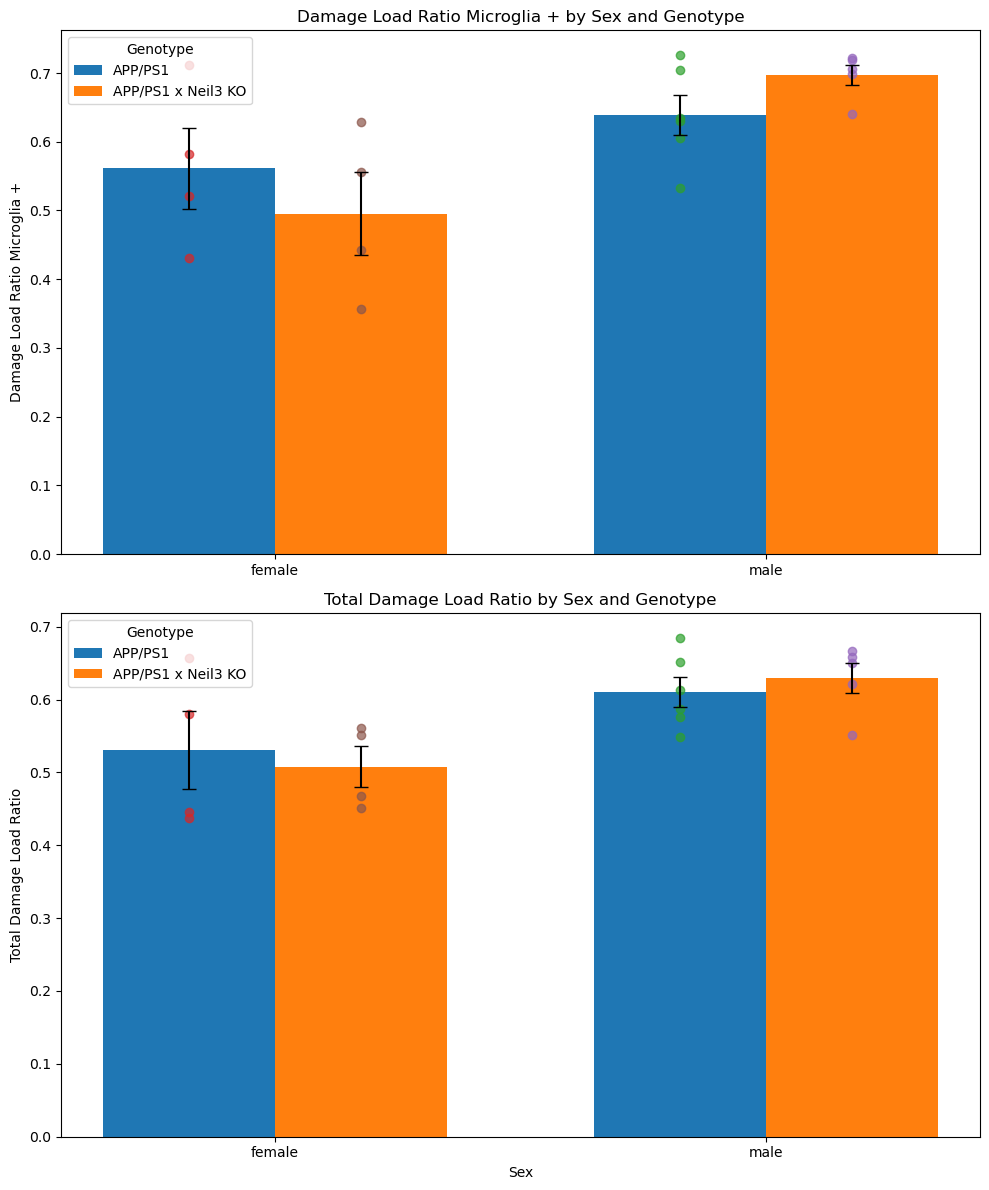

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate means and standard errors of the mean for each group
grouped = result_df.groupby(['sex', 'genotype']).agg({
    'damage_load_ratio_glia_+': ['mean', 'sem'],
    'damage_load_ratio_total': ['mean', 'sem']
}).reset_index()

# Simplify multi-level column names resulting from aggregation
grouped.columns = [' '.join(col).strip() for col in grouped.columns.values]

# Pivoting the table for easier plotting, for both metrics
pivot_glia = grouped.pivot(index='sex', columns='genotype', values='damage_load_ratio_glia_+ mean')
errors_glia = grouped.pivot(index='sex', columns='genotype', values='damage_load_ratio_glia_+ sem')

pivot_total = grouped.pivot(index='sex', columns='genotype', values='damage_load_ratio_total mean')
errors_total = grouped.pivot(index='sex', columns='genotype', values='damage_load_ratio_total sem')

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(pivot_glia))

# Setting figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Create 2 subplots vertically

# Plotting the bars for damage_load_ratio_glia_+
for i, genotype in enumerate(grouped['genotype'].unique()):
    ax1.bar(index + i * bar_width, pivot_glia[genotype], yerr=errors_glia[genotype], 
            width=bar_width, label=genotype, capsize=5)

# Plotting the bars for damage_load_ratio_total
for i, genotype in enumerate(grouped['genotype'].unique()):
    ax2.bar(index + i * bar_width, pivot_total[genotype], yerr=errors_total[genotype], 
            width=bar_width, label=genotype, capsize=5)

# Adding individual points for damage_load_ratio_glia_+
for i, genotype in enumerate(grouped['genotype'].unique()):
    for sex in result_df['sex'].unique():
        subset = result_df[(result_df['genotype'] == genotype) & (result_df['sex'] == sex)]
        x = np.full_like(subset['damage_load_ratio_glia_+'], index[list(pivot_glia.index).index(sex)] + i * bar_width)
        ax1.scatter(x, subset['damage_load_ratio_glia_+'], alpha=0.7)

# Adding individual points for damage_load_ratio_total
for i, genotype in enumerate(grouped['genotype'].unique()):
    for sex in result_df['sex'].unique():
        subset = result_df[(result_df['genotype'] == genotype) & (result_df['sex'] == sex)]
        x = np.full_like(subset['damage_load_ratio_total'], index[list(pivot_total.index).index(sex)] + i * bar_width)
        ax2.scatter(x, subset['damage_load_ratio_total'], alpha=0.7)

# Setting labels and titles
ax1.set_ylabel(f'Damage Load Ratio {dataset.capitalize()} +')
ax1.set_title(f'Damage Load Ratio {dataset.capitalize()} + by Sex and Genotype')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(pivot_glia.index)
ax1.legend(title="Genotype")

ax2.set_xlabel('Sex')
ax2.set_ylabel('Total Damage Load Ratio')
ax2.set_title('Total Damage Load Ratio by Sex and Genotype')
ax2.set_xticks(index + bar_width / 2)
ax2.set_xticklabels(pivot_total.index)
ax2.legend(title="Genotype")

# Show plot
plt.tight_layout()
plt.show()


<h2>Explore failed QC Dataframe</h2>

In [36]:
qc_failed_df = merged_df[merged_df['staining_qc_passed'] == False]

print(f"{qc_failed_df.shape[0]} stains have not passed QC and have been discarded")

qc_failed_df


0 stains have not passed QC and have been discarded


,index,filename,avg_dna_damage_foci/glia_+,avg_dna_damage_foci/glia_+_damage_+,avg_dna_damage_foci/all_nuclei,avg_dna_damage_foci/all_nuclei_damage_+,nr_+_dna_damage_glia_nuclei,nr_+_dna_damage_all_nuclei,nr_-_dna_damage_glia_nuclei,nr_glia_+_nuclei,...,tissue_location,staining_id,animal_id,sex,genotype,dna_damage_stain_quality_manual,manual_qc,glia_stain_quality_auto,dna_damage_stain_quality_auto,staining_qc_passed
